In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import pickle
import phate
import scipy
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from numpy import savetxt
import plotly.graph_objs as go
import scprep
import skdim
import scanpy as sc

In [2]:
import math
import time

import matplotlib.pyplot as plt

import ot as pot

import torch
import torchdyn
from torchdyn.core import NeuralODE
import matplotlib.patches as mpatches

2024-06-17 12:05:43.804906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 12:05:45.174333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/OpenSSL/1.1/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2024-06-17 12:05:45.174863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No s

In [3]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLP2(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.ReLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        with torch.enable_grad():
            x = x.requires_grad_(True)
            grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
            return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        if len(t.shape) == len(x.shape):
            return model(torch.cat([x, t], 1))
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
file_path = "Satija_TGFB1.h5ad"
data = sc.read_h5ad(file_path)

In [5]:
data

AnnData object with n_obs × n_vars = 33362 × 33525
    obs: 'Batch_info', 'bc1_well', 'bc2_well', 'bc3_well', 'cell_type', 'gene', 'guide', 'mixscale_score', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'pathway', 'percent.mito', 'sample', 'sample_ID'
    layers: 'counts'

In [6]:
data.obs["gene"]

CellID
82_66_96_1_1_1_1_1_1_1_1_1     MED15
84_84_79_1_1_1_1_1_1_1_1_1     MED15
84_40_30_1_1_1_1_1_1_1_1_1     SMAD3
82_96_17_1_1_1_1_1_1_1_1_1     SMAD3
82_85_31_1_1_1_1_1_1_1_1_1        NT
                               ...  
83_89_38_2_2                   SMAD3
83_09_57_2_2                   MED15
83_30_46_2_2                      NT
83_30_36_2_2                  TGFBR2
84_03_60_2_2                   SMAD3
Name: gene, Length: 33362, dtype: category
Categories (5, object): ['MED15', 'NT', 'SMAD3', 'TGFBR1', 'TGFBR2']

In [7]:
phate_operator = phate.PHATE(n_components = 2)

phate_emb = phate_operator.fit_transform(data)

Calculating PHATE...
  Running PHATE on 33362 observations and 33525 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 213.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 182.01 seconds.
    Calculating affinities...
    Calculated affinities in 126.92 seconds.
  Calculated graph and diffusion operator in 522.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 138.64 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.35 seconds.
  Calculated landmark operator in 145.20 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 217.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 77.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 21.36 seconds.
Calculated PHATE in 983.74 seconds.


In [8]:
threeD = False
if threeD:
    cmap = plt.cm.get_cmap('Spectral')
    scprep.plot.scatter3d(phate_emb, c = data.obs["gene"], figsize=(12,8), cmap=cmap,
                          ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)

<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

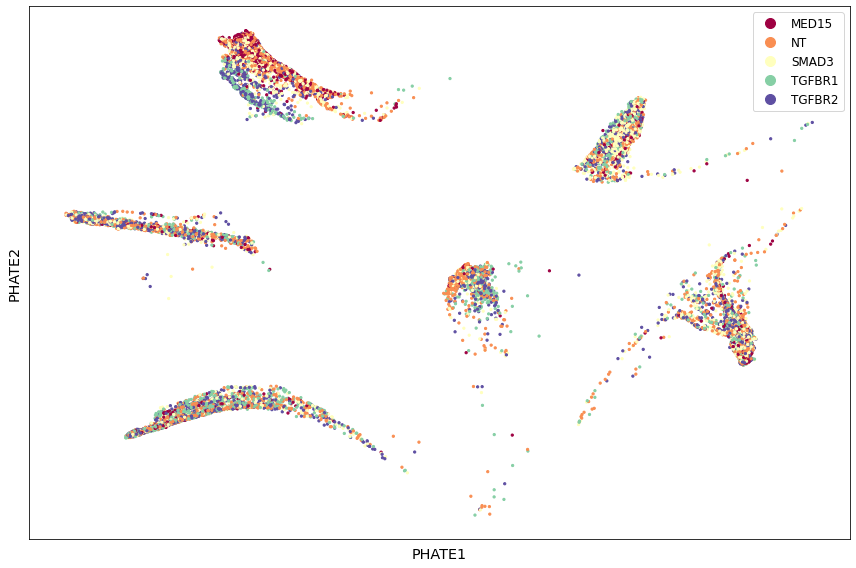

In [9]:
cmap = plt.cm.get_cmap('Spectral')
scprep.plot.scatter2d(phate_emb, c = data.obs["gene"], figsize=(12,8), cmap=cmap,
                      ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)

In [10]:


heatgeo = False
if heatgeo:
    from heatgeo.embedding import HeatGeo
    cmap = plt.cm.get_cmap('Spectral')
    scprep.plot.scatter2d(emb, c = data.obs["cell_type"], figsize=(12,8), cmap=cmap,
                          ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)
    emb_op = HeatGeo(knn=5, emb_dim = 2)
    emb = emb_op.fit_transform(data)

<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

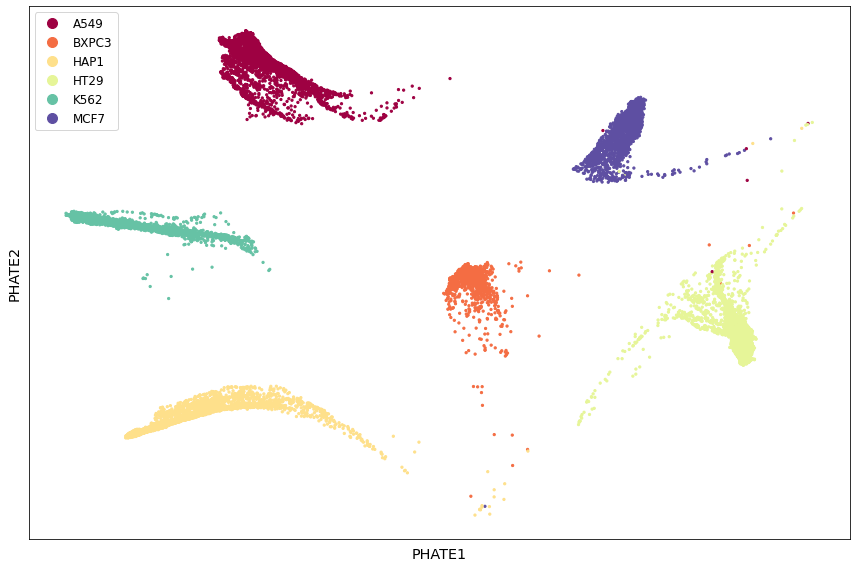

In [11]:
cmap = plt.cm.get_cmap('Spectral')
scprep.plot.scatter2d(phate_emb, c = data.obs["cell_type"], figsize=(12,8), cmap=cmap,
                      ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)

In [12]:
phate_2d_normal = (phate_emb - phate_emb.mean()) / phate_emb.std()
phate_2d_normal.shape

(33362, 2)

In [21]:
for i in data.obs["cell_type"].unique():
    print(i)

A549
HAP1
HT29
K562
MCF7
BXPC3


In [22]:

data.obs["phate_2d_normalizedx"] = phate_2d_normal[:, 0]

data.obs["phate_2d_normalizedy"] = phate_2d_normal[:, 1]

In [23]:
data.obs["phate_2d_normalizedx"][data.obs["gene"] == "MED15"]

CellID
82_66_96_1_1_1_1_1_1_1_1_1   -0.650521
84_84_79_1_1_1_1_1_1_1_1_1   -0.562332
82_20_40_1_1_1_1_1_1_1_1_1   -0.574981
84_63_56_1_1_1_1_1_1_1_1_1   -0.621292
83_69_24_1_1_1_1_1_1_1_1_1   -0.542101
                                ...   
74_57_78_2_2                 -1.032901
74_49_53_2_2                 -1.001390
82_07_90_2_2                  1.026282
84_15_02_2_2                  0.987997
83_09_57_2_2                  0.819026
Name: phate_2d_normalizedx, Length: 3806, dtype: float64

<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

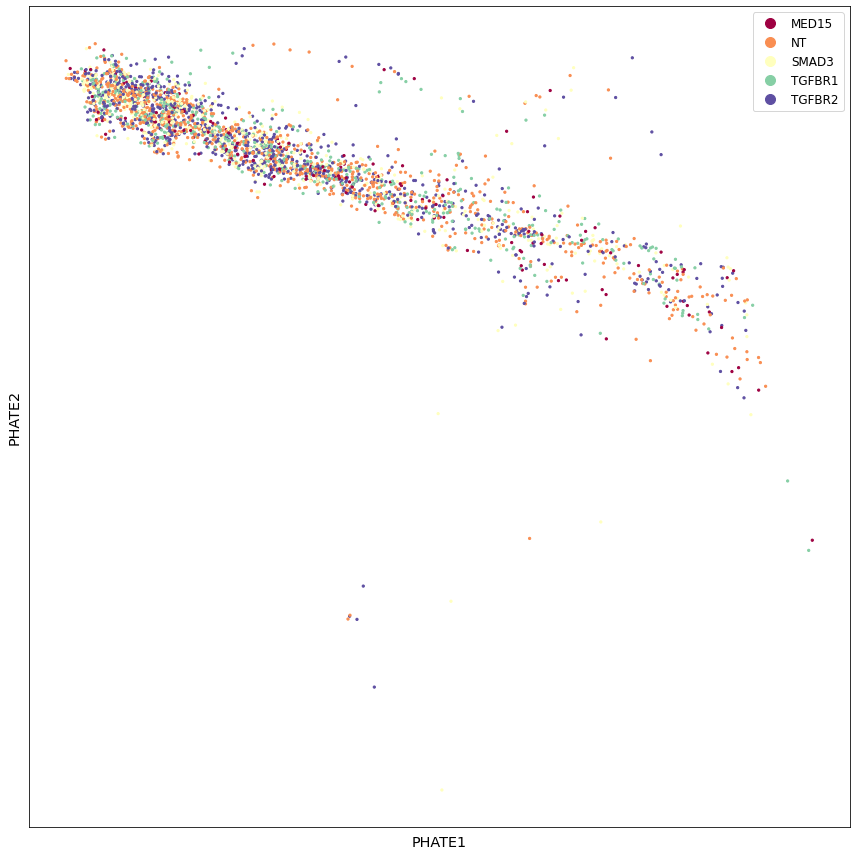

In [24]:
phate1 = data.obs["phate_2d_normalizedx"][data.obs["cell_type"] == "K562"]
phate2 = data.obs["phate_2d_normalizedy"][data.obs["cell_type"] == "K562"]

cc = data.obs["gene"][data.obs["cell_type"] == "K562"]
cell1 = np.column_stack((phate1.values, phate2.values))

scprep.plot.scatter2d(cell1, c = cc.values, figsize=(12,12), cmap=cmap,
                      ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)

In [17]:
data.obs["gene"].unique()

['MED15', 'SMAD3', 'NT', 'TGFBR2', 'TGFBR1']
Categories (5, object): ['MED15', 'NT', 'SMAD3', 'TGFBR1', 'TGFBR2']

In [18]:
data.obs["gene"].cat.codes.unique()

array([0, 2, 1, 4, 3], dtype=int8)

In [19]:
data.obs["gene"]

CellID
82_66_96_1_1_1_1_1_1_1_1_1     MED15
84_84_79_1_1_1_1_1_1_1_1_1     MED15
84_40_30_1_1_1_1_1_1_1_1_1     SMAD3
82_96_17_1_1_1_1_1_1_1_1_1     SMAD3
82_85_31_1_1_1_1_1_1_1_1_1        NT
                               ...  
83_89_38_2_2                   SMAD3
83_09_57_2_2                   MED15
83_30_46_2_2                      NT
83_30_36_2_2                  TGFBR2
84_03_60_2_2                   SMAD3
Name: gene, Length: 33362, dtype: category
Categories (5, object): ['MED15', 'NT', 'SMAD3', 'TGFBR1', 'TGFBR2']

In [24]:
print("Original categories:", data.obs["gene"].cat.categories)
print("Original codes:", data.obs["gene"].cat.codes.unique())

# Define the new order of categories
new_order = ['NT', 'MED15', 'SMAD3', 'TGFBR1', 'TGFBR2']

# Reorder the categories in the specified order
data.obs["gene"] = data.obs["gene"].cat.reorder_categories(new_order, ordered=False)

# Print the updated unique categories and their codes
print("Updated categories:", data.obs["gene"].cat.categories)
print("Updated codes:", data.obs["gene"].cat.codes.unique())

Original categories: Index(['MED15', 'NT', 'SMAD3', 'TGFBR1', 'TGFBR2'], dtype='object')
Original codes: [0 2 1 4 3]
Updated categories: Index(['NT', 'MED15', 'SMAD3', 'TGFBR1', 'TGFBR2'], dtype='object')
Updated codes: [1 2 0 4 3]


In [25]:
data.obs["gene"].cat.codes

CellID
82_66_96_1_1_1_1_1_1_1_1_1    1
84_84_79_1_1_1_1_1_1_1_1_1    1
84_40_30_1_1_1_1_1_1_1_1_1    2
82_96_17_1_1_1_1_1_1_1_1_1    2
82_85_31_1_1_1_1_1_1_1_1_1    0
                             ..
83_89_38_2_2                  2
83_09_57_2_2                  1
83_30_46_2_2                  0
83_30_36_2_2                  4
84_03_60_2_2                  2
Length: 33362, dtype: int8

# dataset

In [25]:
cell_type_list = ["A549", "K562", "HAP1", "BXPC3", "HT29", "MCF7"]


Y = []
for t in cell_type_list:
    array1 = data.obs["phate_2d_normalizedx"][data.obs["gene"] == "NT"][data.obs["cell_type"] == t].values
    array2 = data.obs["phate_2d_normalizedy"][data.obs["gene"] == "NT"][data.obs["cell_type"] == t].values
    
    Y.append(np.column_stack((array1, array2)))

In [85]:
len(Y)

6

In [33]:
%%time
sigma = 0.5
dim = 2
batch_size = 256
action = MLP2(dim=dim, out_dim=1, time_varying=True, w=256)
model = GradModel(action)
score_action = MLP2(dim=dim, out_dim=1, time_varying=True, w=256)
score_model = GradModel(score_action)
optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))

CPU times: user 7.94 ms, sys: 11.5 ms, total: 19.4 ms
Wall time: 99.6 ms


In [36]:
start = time.time()
for k in tqdm(range(50000)):
    optimizer.zero_grad()
    t_select = torch.randint(5, size=(batch_size,))
    x0 = []
    x1 = []
    X_sub = [
        torch.tensor(Y[i][np.random.choice(Y[i].shape[0], size=batch_size, replace=True)], dtype=torch.float32)
        for i in range(6)
    ]

    for i in range(batch_size):
        ti = t_select[i]
        ti_next = ti + 1
        x0.append(X_sub[ti][i])
        x1.append(X_sub[ti_next][i])
    x0, x1 = torch.stack(x0), torch.stack(x1)
    t = torch.rand(batch_size, 1)
    # Resample x0, x1 according to transport matrix
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    # M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma * torch.sqrt(t - t**2)
    x = mu_t + sigma_t * torch.randn_like(x0)
    sigma_t_prime_over_sigma_t = (1 - 2 * t) / (2 * t * (1 - t) + 1e-8)
    ut = sigma_t_prime_over_sigma_t * (x - mu_t) + x1 - x0

    t = t + t_select[:, None]
    vt = model(torch.cat([x, t], dim=-1))
    st = score_model(torch.cat([x, t], dim=-1))
    s_loss = torch.mean((st - ((x - mu_t) / (sigma_t**2 + 1e-4))) ** 2)
    v_loss = torch.mean((vt - ut) ** 2)
    loss = v_loss + s_loss
    loss.backward()
    optimizer.step()
    if (k + 1) % 10000 == 0:
        end = time.time()
        print(
            f"{k+1}: loss {loss.item():0.3f} sloss {s_loss.item():0.3f} vloss {v_loss.item():0.3f} time {(end - start):0.2f}"
        )
        start = end
        continue
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.zeros(batch_size, 1),
                t_span=torch.linspace(0, 5, 100),
            )
            print(traj.shape)
        plot_trajectories(traj)
torch.save(model, "models/sbcfm_v2.pt")
torch.save(score_model, "models/sbcfm_score_v2.pt")

 20%|██        | 10006/50000 [05:27<21:37, 30.83it/s]

10000: loss 31.002 sloss 30.246 vloss 0.756 time 327.07


 40%|████      | 20006/50000 [10:54<16:11, 30.88it/s]

20000: loss 29.651 sloss 28.881 vloss 0.770 time 326.84


 60%|██████    | 30003/50000 [16:20<10:52, 30.66it/s]

30000: loss 33.102 sloss 32.249 vloss 0.853 time 326.21


 80%|████████  | 40005/50000 [21:46<05:23, 30.89it/s]

40000: loss 21.592 sloss 21.241 vloss 0.351 time 326.69


100%|██████████| 50000/50000 [27:13<00:00, 30.61it/s]


50000: loss 16.061 sloss 15.735 vloss 0.326 time 326.67


In [37]:
load = False

if load:
    model = torch.load("models/sbcfm_v2.pt")
    score_model = torch.load("models/sbcfm_score_v2.pt")

<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

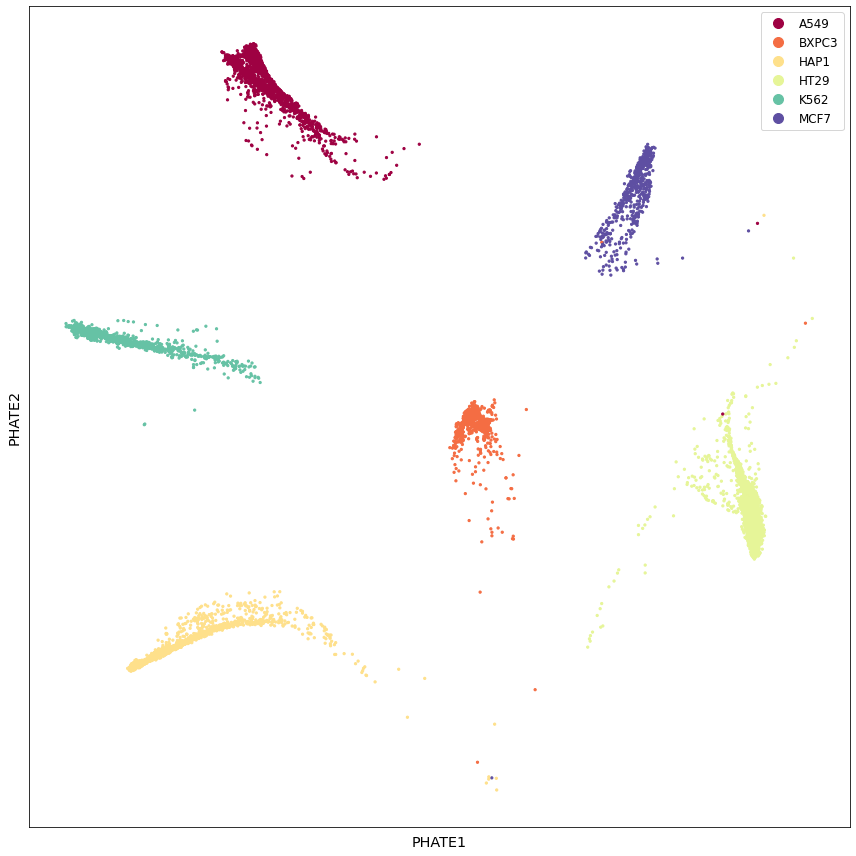

In [40]:
phate1 = data.obs["phate_2d_normalizedx"][data.obs["gene"] == "NT"]
phate2 = data.obs["phate_2d_normalizedy"][data.obs["gene"] == "NT"]

cc = data.obs["cell_type"][data.obs["gene"] == "NT"]
cell1 = np.column_stack((phate1.values, phate2.values))

scprep.plot.scatter2d(cell1, c = cc.values, figsize=(12,12), cmap=cmap,
                      ticks=False, label_prefix="PHATE", fontsize = 10, s = 5)

In [41]:
Ymed15 = []
for t in cell_type_list:
    array1 = data.obs["phate_2d_normalizedx"][data.obs["gene"] == "MED15"][data.obs["cell_type"] == t].values
    array2 = data.obs["phate_2d_normalizedy"][data.obs["gene"] == "MED15"][data.obs["cell_type"] == t].values
    
    Ymed15.append(np.column_stack((array1, array2)))

In [42]:
import math


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, sigma):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x) - self.sigma**2 * self.score(x)

    # Diffusion
    def g(self, t, y):
        return self.sigma * torch.ones_like(y)

In [43]:
Ymed15[0].shape

(2032, 2)

In [52]:
x0 = torch.tensor(Y[0][np.random.choice(Y[0].shape[0], size=batch_size, replace=True)], dtype=torch.float32)

import torchsde

sde = SDE(model, score_model, sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0,
        ts=torch.linspace(0, 5, 200),
        method="srk",
    )

In [65]:
traj.shape

torch.Size([200, 256, 2])

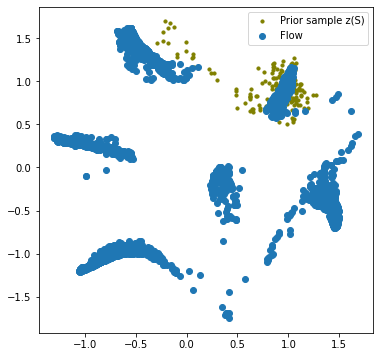

In [84]:
cc = data.obs["cell_type"][data.obs["gene"] == "NT"]

n = 2
traj = sde_traj
plt.figure(figsize=(6, 6))
#plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[n * 50 -1, :, 0], traj[n * 50 -1, :, 1], s=10, alpha=1, c="olive")
plt.scatter(cell1[:, 0], cell1[:, 1])
#plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])

plt.show()

In [35]:
from scipy.spatial.distance import cdist

def PNNP(perturbed_GT, perturbed_predicted):
    # Concatenate the arrays along the first axis
    concatenated = np.vstack((perturbed_GT, perturbed_predicted))
    
    # Compute the pairwise distances
    distances = cdist(concatenated, concatenated)
    
    # Set self-distances to a very high value to avoid self-matching
    np.fill_diagonal(distances, np.inf)
    
    # Find the index of the nearest neighbor for each observation
    nearest_neighbors = np.argmin(distances, axis=1)
    
    # Total number of observations in perturbed_GT and perturbed_predicted
    num_GT = perturbed_GT.shape[0]
    num_predicted = perturbed_predicted.shape[0]
    
    # Identify the group of each observation
    labels = np.array(['GT'] * num_GT + ['Predicted'] * num_predicted)
    
    # Count how many perturbed_predicted have nearest neighbors also in perturbed_predicted
    predicted_indices = range(num_GT, num_GT + num_predicted)
    neighbor_counts = sum(labels[nearest_neighbors[i]] == 'Predicted' for i in predicted_indices)
    
    # Calculate percentage
    percentage_mixed = 100 * neighbor_counts / num_predicted
    
    return percentage_mixed

In [36]:
n = 4
PNNP(Ytest[n][np.random.choice(Ytest[n].shape[0], size=batch_size, replace=True)], traj[n * 50 -1])

100.0

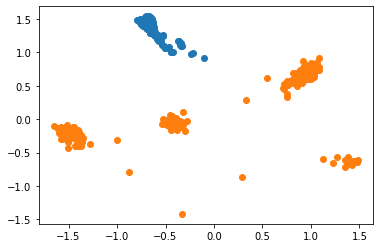

In [53]:
n = 0
A = Ytest[n][np.random.choice(Ytest[n].shape[0], size=batch_size, replace=True)]
B = traj[n * 50 -1]
plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1])

## Test in Umap space

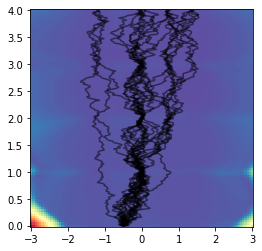

In [39]:
w = 3
points = 100j
points_real = 100
Z, T = np.mgrid[-w:w:points, 0:4:100j]
gridpoints = torch.tensor(np.stack([Z.flatten(), T.flatten()], axis=1), requires_grad=True).type(
    torch.float32
)
out = action(gridpoints)
out = out - sigma**2 * score_action(gridpoints)
out = out.reshape([points_real, 100]).detach().numpy()

import torchsde

x0 = X_sub[0][:100]
sde = SDE(model, score_model, sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0,
        ts=torch.linspace(0, 4, 200),
        method="srk",
    )
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.pcolormesh(Z, T, out, cmap="Spectral")
for i in range(20):
    plt.plot(sde_traj[:, i, 0], np.linspace(0, 4, 200), c="k", alpha=0.5)

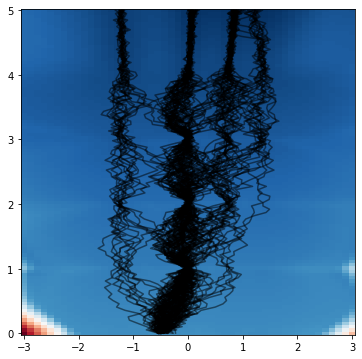

In [80]:
Y = []
for t in range(6):
    Y.append(data.obs["phate_1d_normalized"][data.obs["cell_type"].cat.codes == t].values)
X_sub = [
    torch.tensor(np.random.choice(Y[i], size=100, replace=True), dtype=torch.float32)[:, None]
    for i in range(6)
]
x0 = X_sub[0]

w = 3
points = 50j
points_real = 50
X, T = np.mgrid[-w:w:points, 0:5:100j]
gridpoints = torch.tensor(np.stack([X.flatten(), T.flatten()], axis=1), requires_grad=True).type(
    torch.float32
)
out = action(gridpoints) - sigma**2 * score_action(gridpoints)
out = -out.reshape([points_real, 100]).detach().numpy()
sde = SDE(model, score_model, sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0,
        ts=torch.linspace(0, 5, 100),
        method="srk",
    )

a = torch.linspace(0, 5, 100)[:, None, None].repeat(1, x0.shape[0], 1)

inp = torch.cat([sde_traj, a], dim=-1)
potentials = -(action(inp) - sigma**2 * score_action(inp))
pots = potentials.mean(dim=[-2])
# level based on sampled trajectories
normed_outs = out - pots.detach().numpy().T
nmean = normed_outs.mean()
nstd = normed_outs.std()
normed_outs = (normed_outs - nmean) / nstd
normed_outs -= np.linspace(0, 4, 100)[None, :]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(X, T, normed_outs, cmap="RdBu_r")

for i in range(100):
    plt.plot(sde_traj[:, i, 0], np.linspace(0, 5, 100), c="k", alpha=0.5)

normed_potentials = potentials - potentials.mean(dim=-2, keepdim=True)
normed_potentials = (normed_potentials - nmean) / nstd
normed_potentials = normed_potentials - torch.linspace(0, 4, 100)[:, None, None]

sde_traj_3d = torch.cat([inp, normed_potentials + 0.1], dim=-1).detach().numpy()

In [81]:
X = np.stack(
    [
        phate_1d_normal.squeeze(),
        data.obs["cell_type"].cat.codes,
    ],
    axis=1,
)
X.shape

(33362, 2)

In [82]:
data_torch = torch.from_numpy(X).type_as(inp)
data_potentials = -(action(data_torch) - sigma**2 * score_action(data_torch))
npots = []
for i in range(6):
    mask = torch.abs(data_torch[:, 1] - i) < 1e-4
    zeroed_pots = data_potentials[mask] - data_potentials[mask].mean()
    normed_pots = (zeroed_pots - nmean) / nstd
    normed_pots = normed_pots - torch.linspace(0, 3, 6)[i]
    npots.append(normed_pots)
normed_potentials = torch.cat(npots)
data_torch[:, 1] = torch.from_numpy(
    (data.obs["cell_type"].cat.codes + np.random.randn(*[data.obs["cell_type"].cat.codes.shape[0]]) * 0.1).values
)
data_3d = torch.cat([data_torch, normed_potentials], dim=1).detach().numpy()
data_3d_subset = data_3d[np.random.randint(data_3d.shape[0], size=800)]

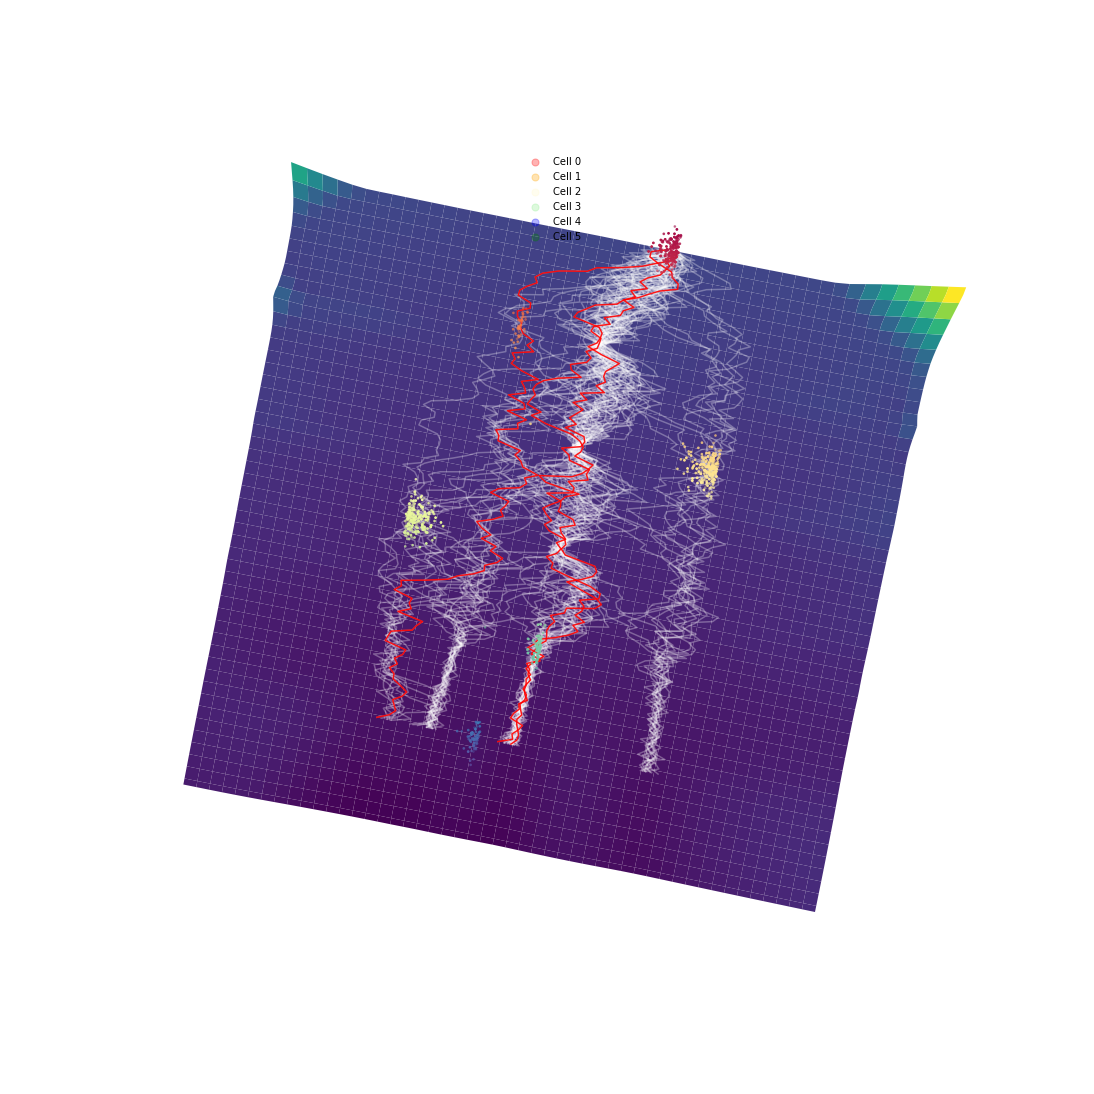

In [83]:
Z, T = np.mgrid[-w:w:points, 0:6:100j]

fig = plt.figure(figsize = (15, 15))

ax = plt.axes(projection="3d", computed_zorder=False)
ax.plot_surface(Z, T, normed_outs, cmap="viridis", linewidth=0.1, zorder=0)
for i in range(60):
    ax.plot3D(
        sde_traj_3d[:, i, 0],
        sde_traj_3d[:, i, 1],
        sde_traj_3d[:, i, 2],
        c="w",
        alpha=0.3,
        zorder=1,
    )
ax.scatter3D(
    data_3d_subset[:, 0],
    data_3d_subset[:, 1],
    data_3d_subset[:, 2],
    zorder=2,
    c=data_3d_subset[:, 1],
    cmap="Spectral",
    s=3
)
for i in range(5, 8):
    ax.plot3D(
        sde_traj_3d[:, i, 0],
        sde_traj_3d[:, i, 1],
        sde_traj_3d[:, i, 2],
        c="r",
        alpha=0.9,
        zorder=1,
    )
#ax.legend()
#plt.legend(loc="upper right")

ax.axis("off")
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0,0)

#red_patch = mpatches.Circle((0.5, 0.5), radius = 0.25, color='red', label='The red data')
#blue_patch = mpatches.Circle((0.5, 0.5), radius = 0.25, color='blue', label='The blue data')
#plt.legend(handles=[red_patch, blue_patch], loc='upper right')
#plt.plot([],[], marker="o", ms=10, ls="")
legend = {'Cell 0': "red", 'Cell 1': "orange", 'Cell 2': "lemonchiffon",
          'Cell 3': "lightgreen", 'Cell 4': "blue", 'Cell 5': "green"}
for day in legend.keys():
    plt.scatter([], [], c = legend[day], alpha=0.3, s=50,
                label=str(day))
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, bbox_to_anchor=(0.54,0.87))

ax.view_init(90, 100)
#plt.savefig("figures/eb_landscape_1.png", dpi=300, bbox_inches='tight')
plt.show()